# Creating Melody Lines from Station Data

In [198]:
#Add the python libraries we're going to use
import pandas as pd
import pygame
import ulmo
import sys
import pickle
from music21 import *
import pandas as pd
import seaborn as sns
from optparse import OptionParser
from pyknon.genmidi import Midi
from pyknon.music import NoteSeq, Note, Rest
from data_mapping import convert_scale, map_to_range
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 
pd.set_option('display.width',800)
plt.rcParams['figure.figsize'] = [15, 5]

In [ ]:
# settings to display music score
environment.UserSettings()['lilypondPath'] = '/Applications/LilyPond.app/Contents/Resources/bin/lilypond'
environment.UserSettings()['pdfPath'] =  '/Applications/MuseScore 3.app/Contents/MacOS/mscore'
environment.UserSettings()['graphicsPath'] =  '/Applications/MuseScore 3.app/Contents/MacOS/mscore'
environment.UserSettings()['musescoreDirectPNGPath'] = '/Applications/MuseScore 3.app/Contents/MacOS/mscore'

In [7]:
#%% Functions 
def get_command_options():
    # Get the search and variables to plot from the command line
    parser = OptionParser()
    parser.add_option('-s', '--search', dest='search', action='store', 
                      type='string', default='none', 
                      help='Search string to list matching stations.')
    parser.add_option('-f', '--file-name', dest='file_name', action='store', 
                      type='string', default='./.data.pkl', 
                      help='File name to save data')
    opts, args = parser.parse_args()
    return opts, args

In [8]:
#%% Initialize
options, arguments = get_command_options()
search = options.search.upper()
file_name = options.file_name

In [9]:
#%% Search
# This section is used to list stations containing a search string (in CAPS) 
# provided by the command line option -s.

if search != 'NONE':
    print('Finding stations matching string "%s"...' % search)
    st = ulmo.ncdc.ghcn_daily.get_stations(country='US', as_dataframe=True)
    print(st[st.name.str.contains(search)])
    sys.exit()


In [10]:
#Specify the Stations we want
#seatac: USW0002423
arguments =  ["USW00024233", 'SeaTac']

In [108]:
#%% Data retrieval section
if len(arguments) < 1:
    raise ValueError('must provide a GHCN station ID as arguments')
station_id = arguments[0]

print('Retrieving data from %s...' % station_id)
data = ulmo.ncdc.ghcn_daily.get_data(station_id, as_dataframe=True)

#print('Saving to %s' % file_name)
#with open(file_name, 'wb') as f:
#    pickle.dump(data, f, pickle.HIGHEST_PROTOCOL)

Retrieving data from USW00024233...


/Users/judytwedt/anaconda/lib/python3.6/site-packages/ulmo/ncdc/ghcn_daily/core.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  axis=1)
/Users/judytwedt/anaconda/lib/python3.6/site-packages/ulmo/ncdc/ghcn_daily/core.py:95: FutureWarning: 
.resample() is now a deferred operation
You called index(...) on this deferred object which materialized it into a dataframe
by implicitly taking the mean.  Use .resample(...).mean() instead
  daily_index = element_df.resample('D').index.copy()


In [111]:
#Examine the station data parameters -- this varies considerably between stations
data.keys()

dict_keys(['ACMH', 'ACSH', 'AWND', 'FMTM', 'FRGT', 'PGTM', 'PRCP', 'PSUN', 'SNOW', 'SNWD', 'TAVG', 'THIC', 'TMAX', 'TMIN', 'TSUN', 'WDF1', 'WDF2', 'WDF5', 'WDFG', 'WDFM', 'WESD', 'WSF1', 'WSF2', 'WSF5', 'WSFG', 'WSFM', 'WT01', 'WT02', 'WT03', 'WT04', 'WT05', 'WT06', 'WT07', 'WT08', 'WT09', 'WT11', 'WT13', 'WT14', 'WT15', 'WT16', 'WT17', 'WT18', 'WT19', 'WT21', 'WT22', 'WV01', 'WV03', 'WV20'])

In [112]:
tmx = data['TMAX'].copy() #maximum daily temperature
ta = data['TAVG'].copy()  # average daily temperature
tmn = data['TMIN'].copy() # minimum daily temperature

In [113]:
# convert to degrees Fahrenheit
tmx.value=tmx.value*9/50.0 + 32.0

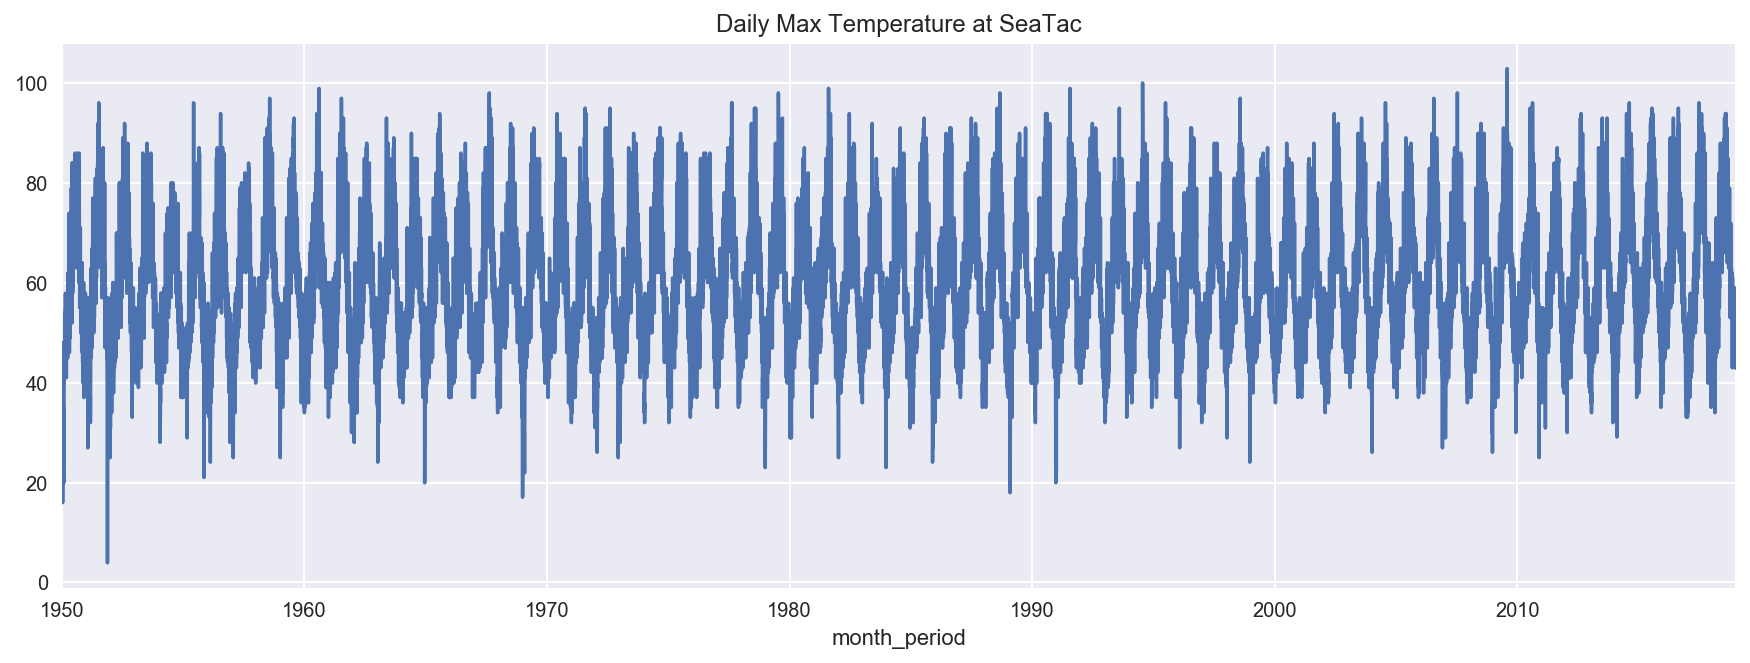

In [203]:
tmx['value']['1950':'2018'].plot()
plt.title('Daily Max Temperature at % s' % arguments[1])


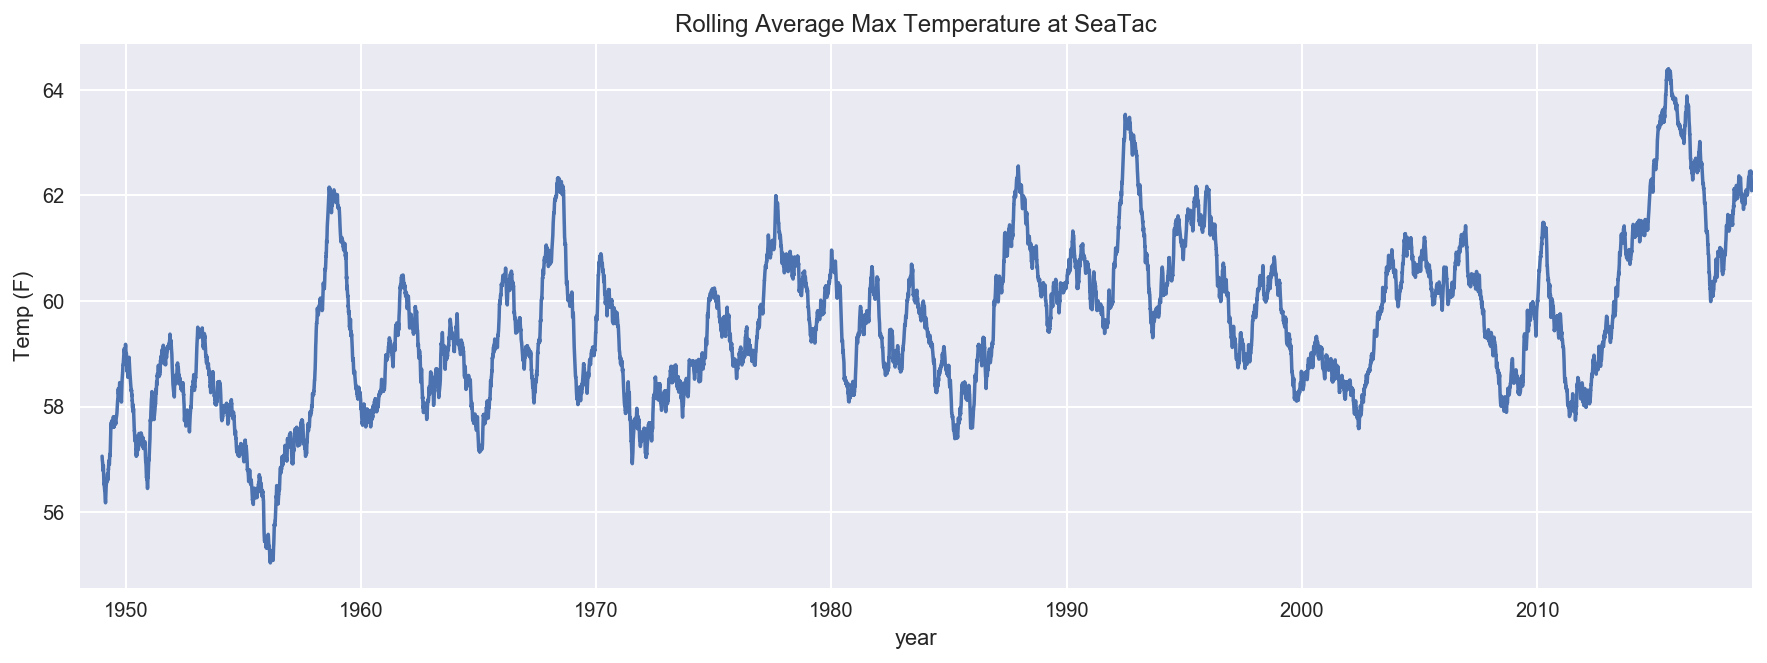

In [200]:
tmx.value.rolling(window=365).mean().plot()
plt.title('Rolling Average Max Temperature at % s' % arguments[1])
plt.ylabel('Temp (F)')
plt.xlabel('year')

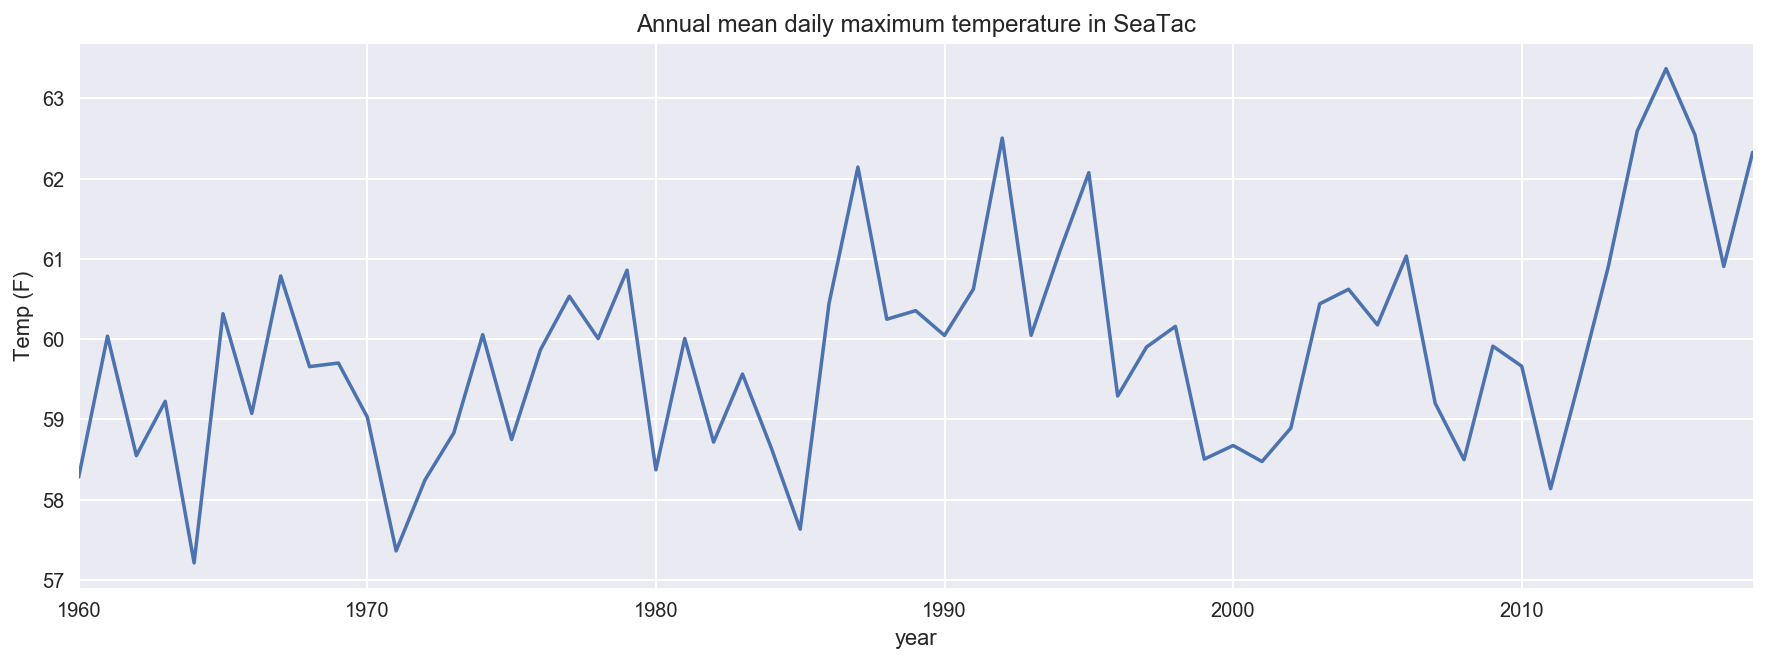

In [201]:
tmx.value = tmx.value.astype('float')
tmx['1960':'2018'].value.resample('A').mean().plot()
plt.title('Annual mean daily maximum temperature in %s' % arguments[1])
plt.ylabel('Temp (F)')
plt.xlabel('year')

#### There's a lot of year-to-year variability in the data, and the record has too many entries to make a melody. We can take 5 and 10 year averages to create a smaller set of data points that still contains information about how temperature is changing over time. 


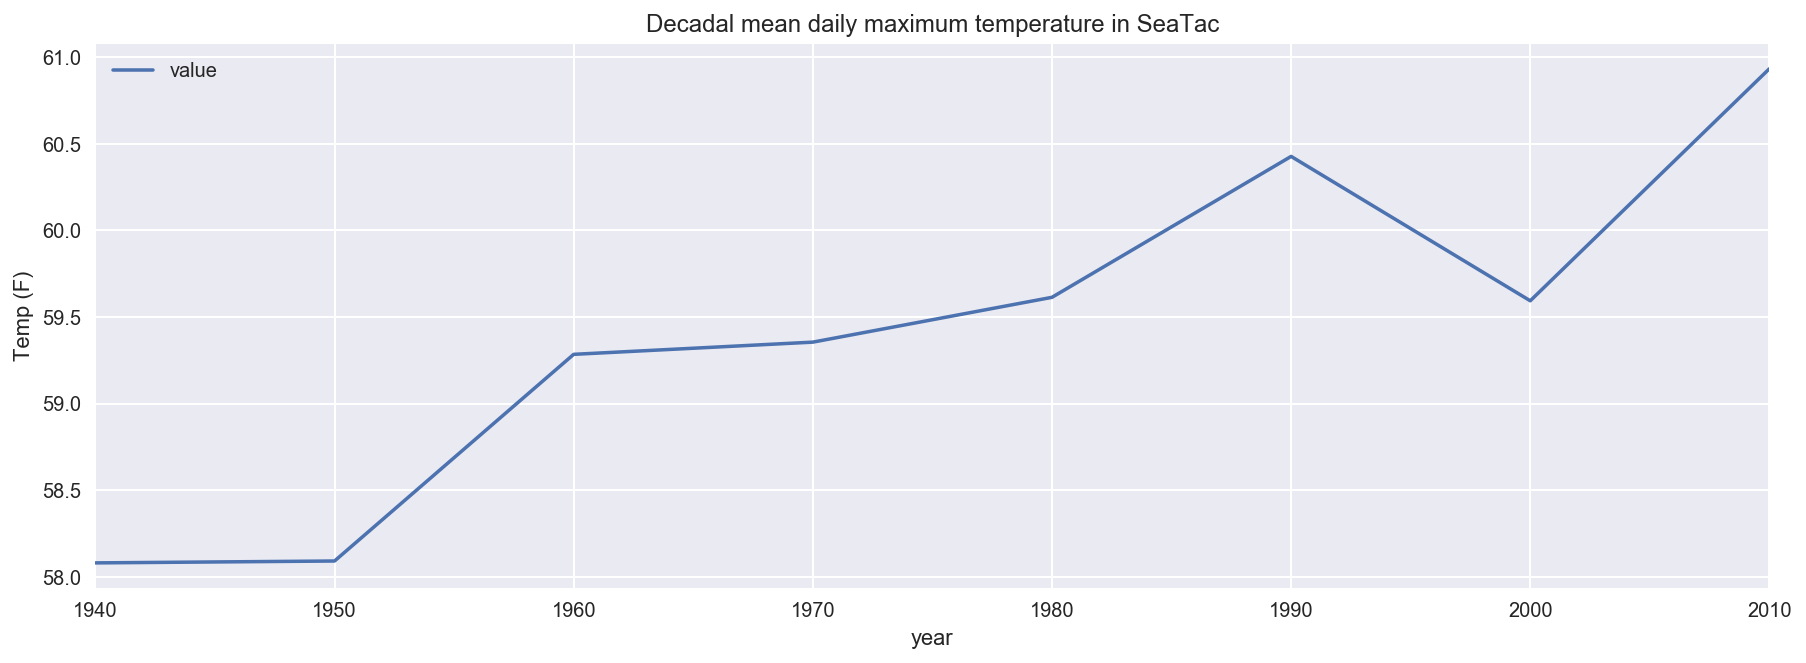

In [204]:
tmx_decade = tmx.groupby((tmx.index.year//10)*10).mean()
tmx_decade.plot()
plt.title('Decadal mean daily maximum temperature in %s' % arguments[1])
plt.ylabel('Temp (F)')
plt.xlabel('year')

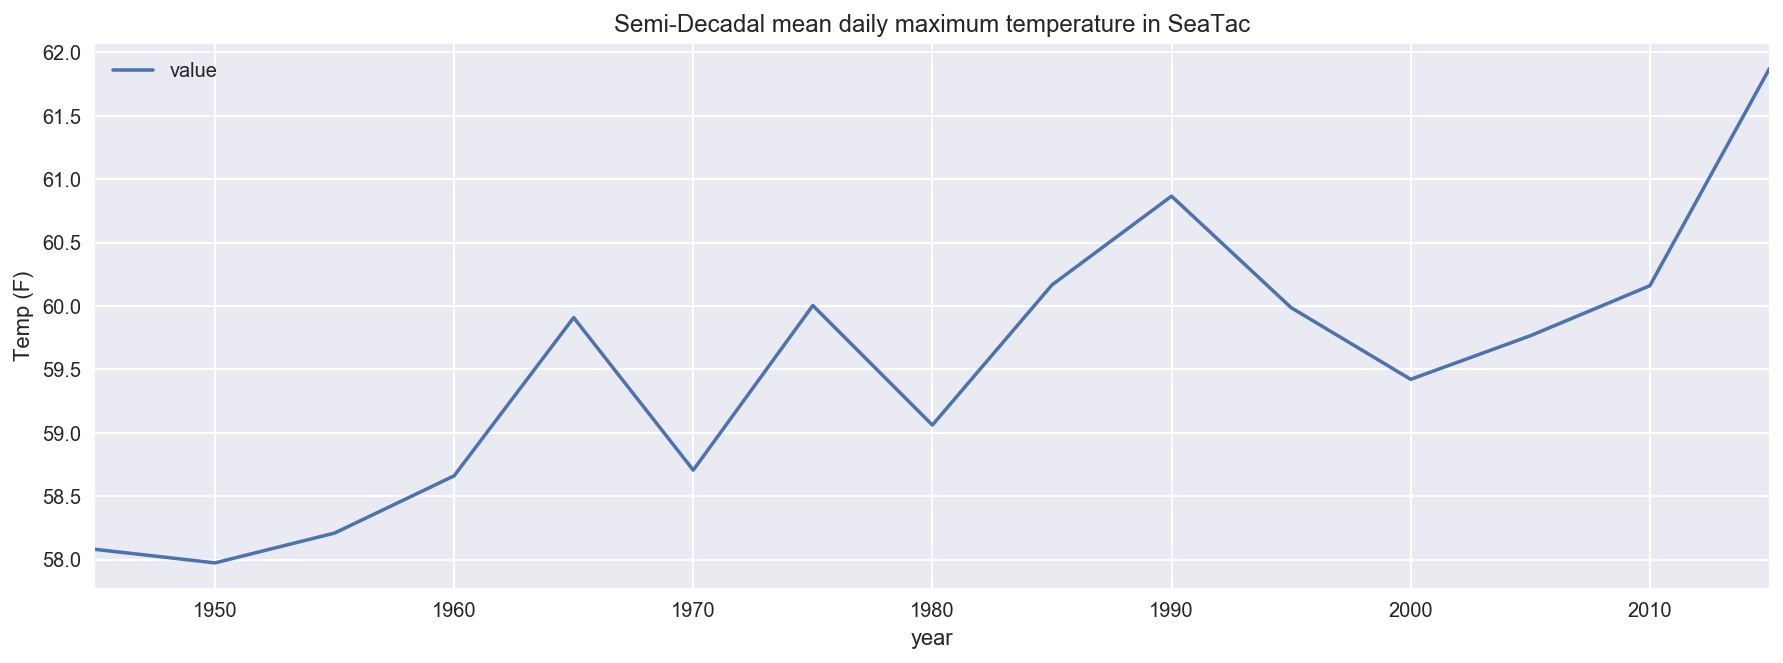

In [205]:
tmx_5yr = tmx.groupby((tmx.index.year//5)*5).mean()
tmx_5yr.plot()
plt.title('Semi-Decadal mean daily maximum temperature in %s' % arguments[1])
plt.ylabel('Temp (F)')
plt.xlabel('year')

# Sonification!


##### Turn the decadal and semi-decadal averages into melody lines. Explore using different scales, start notes, and ranges. 

In [168]:
#Functions
def sonify(x, octRange = 2,ntones = 11, baseOct = 4):
    #sonify the series
    octs,notes = map_to_range(x,octRange, ntones,baseOct)
    return octs, notes
        
def convert_scale(octs, notes, key = 0, scale = 'major'):
    if scale == 'major':
         newscale = np.asarray([0, 2, 4, 5, 7, 9, 11]) + key
    elif scale == 'harm_minor':	
        newscale = np.asarray([0,2,3,5,7,8,11]) + key
    elif scale == 'nat_minor':
        newscale = np.asarray([0,2,3,5,7,8,10]) + key
    elif scale == 'wholetone':
        newscale = np.asarray([0,2,4,6,8,10]) + key	
        # optional write-in
    else:
        newscale = scale + key
    notes_in_key = np.full(len(notes), np.nan)
    tones = np.unique(notes[~np.isnan(notes)])
    i = 0
    for tone in tones:
        notes_in_key[notes == tone] = newscale[i]
        i+=1
    return NoteSeq([Note(notes_in_key[j], octs[j], 1/8) for j in range(len(notes))])
        
def sonify_stationData(stationData,fname, params1, params2, theTempo = 150):
    fnames = []
    for x in params1:
        octs, tones, base, string1 = x
        for y in params2:
            key, scale, string2 = y
            theOcts, theNotes = sonify(theData, octs, tones, base)
            sonic = convert_scale(theOcts, theNotes, key, scale)
            goo = Midi(tempo = theTempo)
            goo.seq_notes(sonic)
            midiname = fname + string1 + string2 + '.mid'
            goo.write(midiname)
            fnames.append(midiname)
    return fnames

In [189]:
#Decadal
params1 = [[1, 7, 4, '174'],[2, 7, 4, '274']] ## nOctaves, nTones
params2 = [[0, 'major', '0Maj'], [0, 'harm_minor', '0hMin'], [3, 'harm_minor', '3hMin']] # key, scale
theData = tmx_decade.values.flatten()
theTempo = 130
fname = 'SeaTacStation/SeaTac_decadal_'
decadalMidiFiles = sonify_stationData(theData,fname, params1, params2)

In [190]:
#Semi decadal
params1 = [[1, 7, 4, '174'],[2, 7, 4, '274']] ## nOctaves, nTones
params2 = [[0, 'major', '0Maj'], [0, 'harm_minor', '0hMin'],[3, 'harm_minor', '3hMin']] # key, scale
theData = tmx_5yr.values.flatten()
theTempo = 130
fname = 'SeaTacStation/SeaTac_semiDecadal_'
semiDecadalMidiFiles = sonify_stationData(theData,fname, params1, params2)

### Display the data in music notation
###### Choosing different scales and pitch ranges for the notes is analogous to choosing different color palletes and axes ranges in data vis

### Decadal Average TMAX 

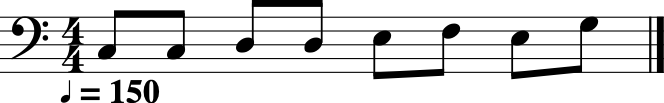

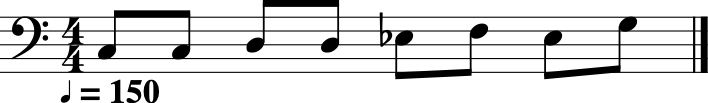

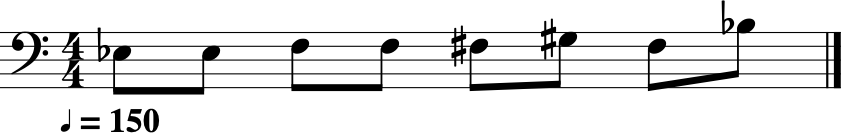

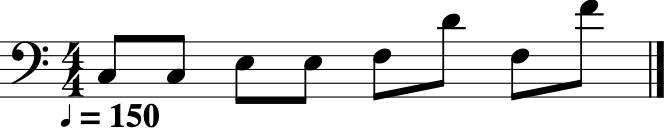

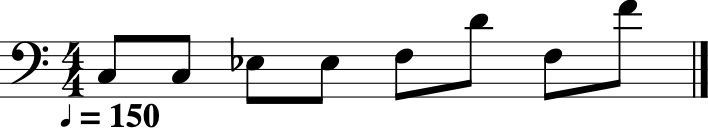

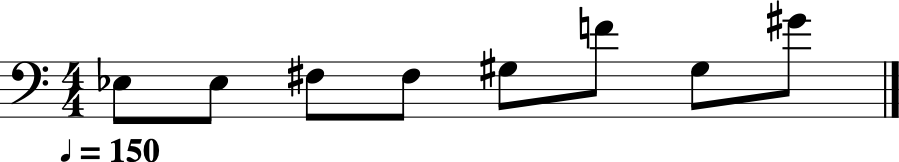

In [193]:
for midFile in decadalMidiFiles:
    converter.parse(midFile).show()

### Semi-Decadal Average TMAX

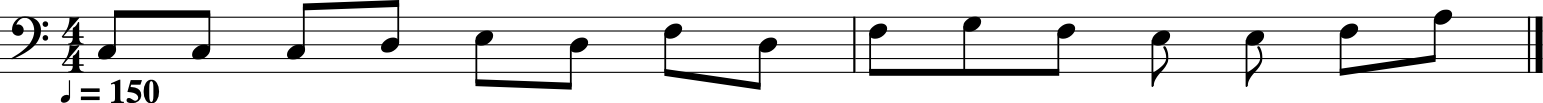

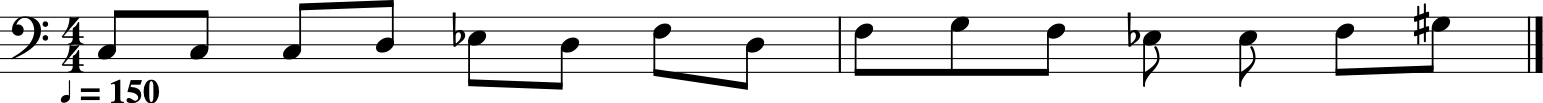

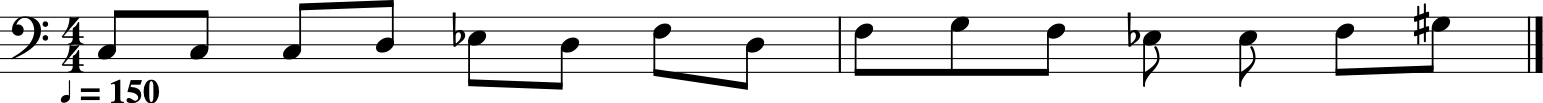

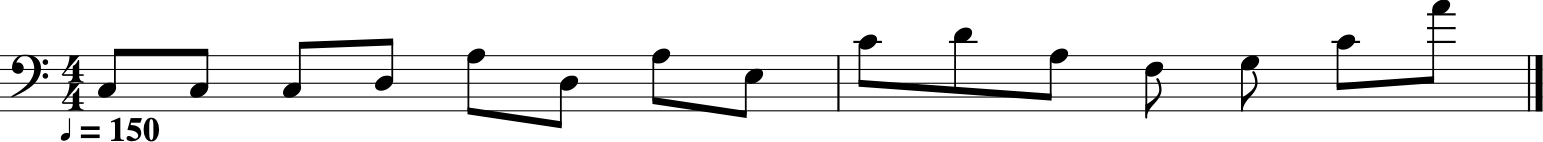

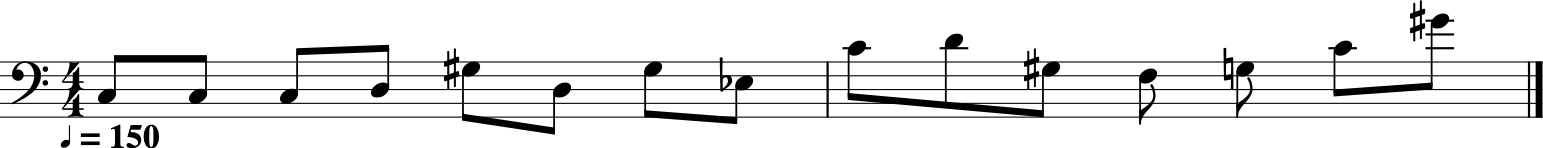

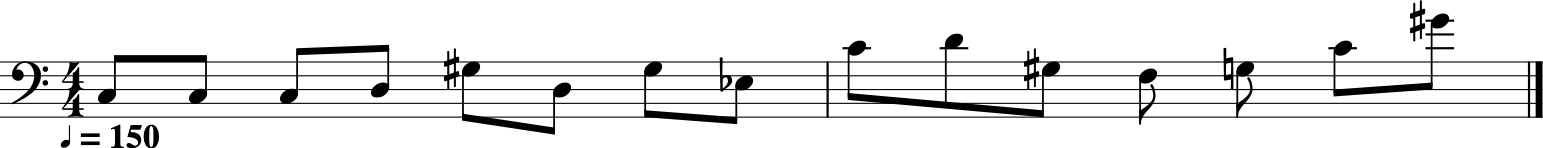

In [177]:
for midFile in semiDecadalMidiFiles:
    converter.parse(midFile).show()